In [36]:
%matplotlib inline
import os, json, cv2, numpy as np, matplotlib.pyplot as plt
import copy

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

import albumentations as A # Library for augmentations

In [37]:
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

In [42]:
def train_transform():
    return A.Compose([
        A.Sequential([
            # A.RandomRotate90(p=0.1), # Random rotation of an image by 90 degrees zero or more times
            A.HorizontalFlip(p=0.25), # Random flip of an image zero or more times
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

In [43]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
            
            # All objects are Paintings
            bboxes_labels_original = ['Painting' for _ in bboxes_original]            

        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            
            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,4,2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are Paintings
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)
        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are Paintings
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)

In [44]:
KEYPOINTS_FOLDER_TRAIN = './pfd_dataset/test/'
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

print("Original targets:\n", batch[3], "\n\n")
print("Transformed targets:\n", batch[1])

Original targets:
 ({'boxes': tensor([[ 42.,   5., 447., 351.]]), 'labels': tensor([1]), 'image_id': tensor([28]), 'area': tensor([140130.]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[ 44.,  14.,   1.],
         [ 56., 330.,   1.],
         [443., 346.,   1.],
         [439.,   7.,   1.]]])},) 


Transformed targets:
 ({'boxes': tensor([[ 42.,   5., 447., 351.]]), 'labels': tensor([1]), 'image_id': tensor([28]), 'area': tensor([140130.]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[ 44.,  14.,   1.],
         [ 56., 330.,   1.],
         [443., 346.,   1.],
         [439.,   7.,   1.]]])},)


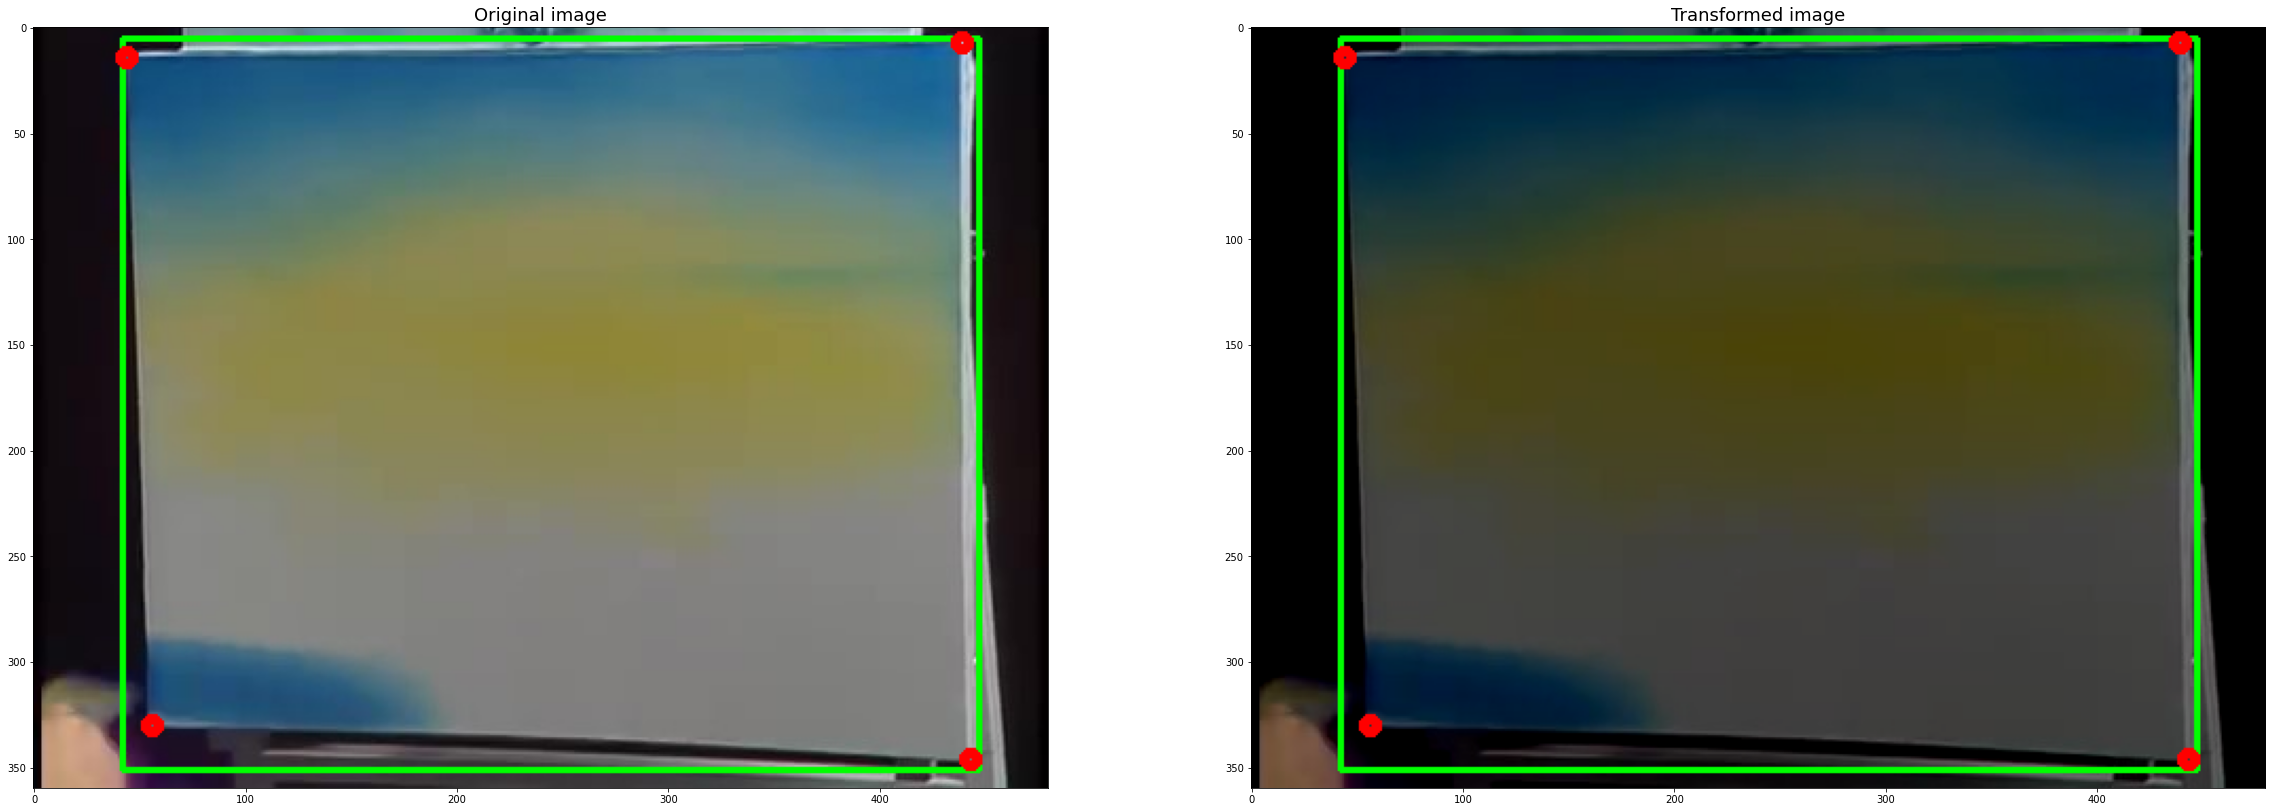

In [45]:
keypoints_classes_ids2names = {0: '', 1: ''}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 3, (255,0,0), 4)
            # image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 3, (255,0,0), 4)
                # image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

In [46]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [47]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

KEYPOINTS_FOLDER_TRAIN = './pfd_dataset/train'
KEYPOINTS_FOLDER_TEST = './pfd_dataset/test'

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=None, demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=3, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

model = get_model(num_keypoints = 4)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 50

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)

# Save model weights after training
torch.save(model.state_dict(), './keypoint_model/weights/keypointsrcnn_weights.pth')

Epoch: [0]  [ 0/52]  eta: 0:00:10  lr: 0.000021  loss: 9.5154 (9.5154)  loss_classifier: 0.7619 (0.7619)  loss_box_reg: 0.0104 (0.0104)  loss_keypoint: 8.0533 (8.0533)  loss_objectness: 0.6845 (0.6845)  loss_rpn_box_reg: 0.0053 (0.0053)  time: 0.1928  data: 0.0659  max mem: 5816
Epoch: [0]  [51/52]  eta: 0:00:00  lr: 0.001000  loss: 6.8882 (7.8958)  loss_classifier: 0.0668 (0.2772)  loss_box_reg: 0.0374 (0.0309)  loss_keypoint: 6.2671 (7.0215)  loss_objectness: 0.3480 (0.5528)  loss_rpn_box_reg: 0.0086 (0.0133)  time: 0.1775  data: 0.0500  max mem: 5816
Epoch: [0] Total time: 0:00:08 (0.1723 s / it)
creating index...
index created!
Test:  [ 0/39]  eta: 0:00:01  model_time: 0.0391 (0.0391)  evaluator_time: 0.0049 (0.0049)  time: 0.0513  data: 0.0067  max mem: 5816
Test:  [38/39]  eta: 0:00:00  model_time: 0.0297 (0.0347)  evaluator_time: 0.0035 (0.0041)  time: 0.0663  data: 0.0255  max mem: 5816
Test: Total time: 0:00:02 (0.0637 s / it)
Averaged stats: model_time: 0.0297 (0.0347)  evalu

In [48]:
iterator = iter(data_loader_test)

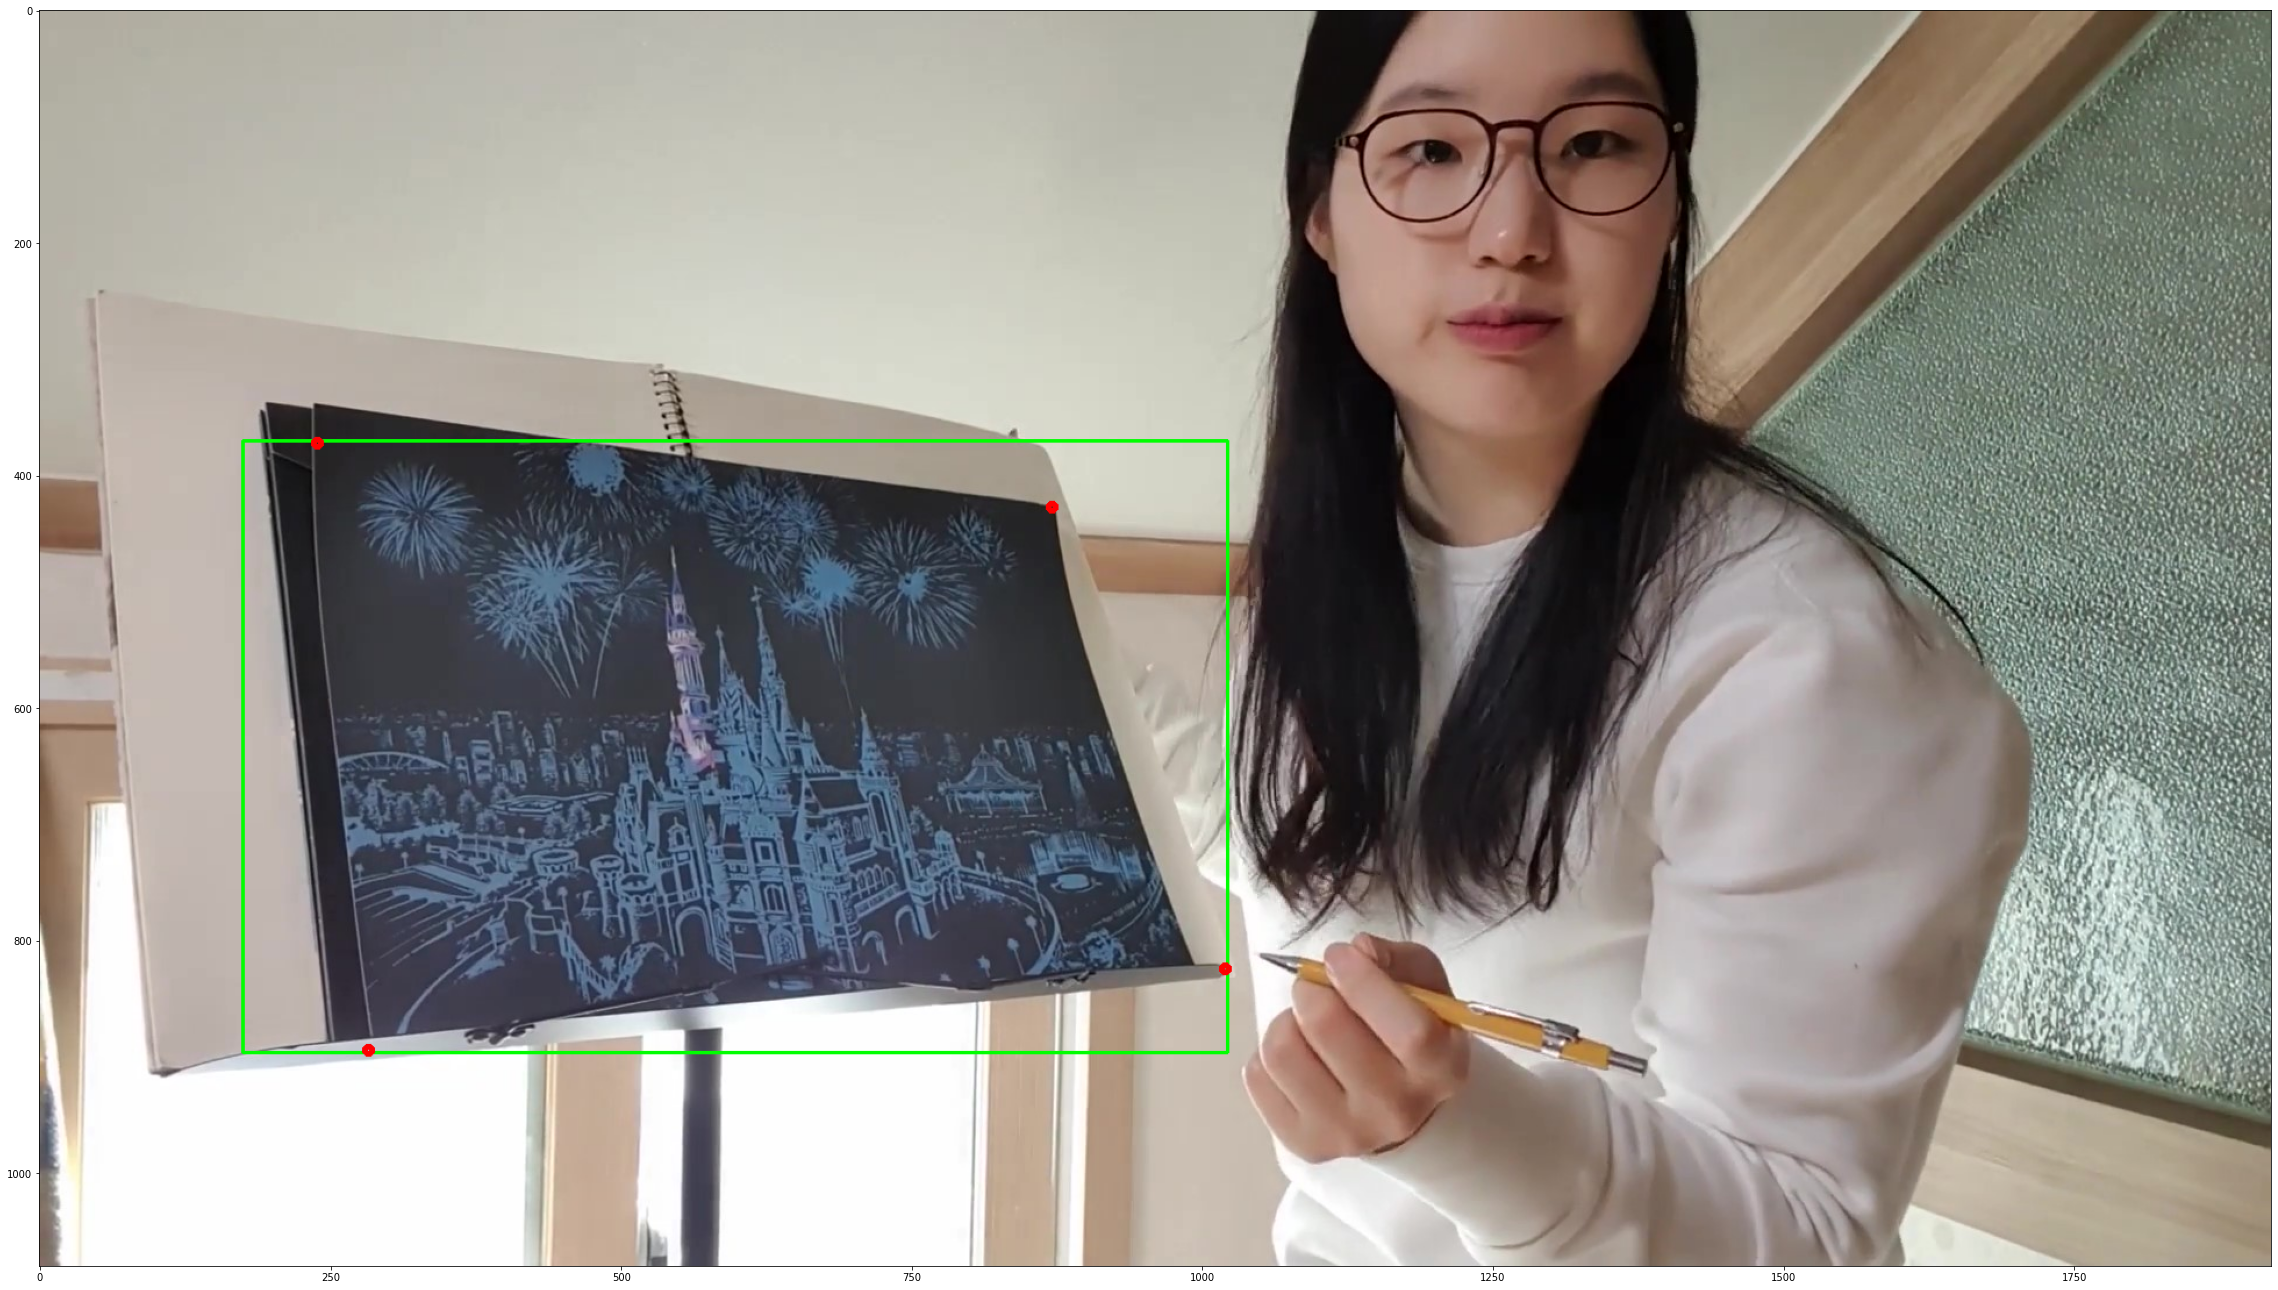

In [57]:
images, targets = next(iterator)

images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

image = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])
    
bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image, bboxes, keypoints)

### Save Model

In [418]:
torch.save(model, './keypoint_model/model.pt')

### Play through video and draw keypoints on it

In [381]:
def sort_points(all_points_x, all_points_y):
    points = []

    for x, y in zip(all_points_x, all_points_y):
        points.append([x, y])

    center = (sum(all_points_x)/len(all_points_x), sum(all_points_y)/len(all_points_y))

    top_left = [0, 0]
    top_right = [0, 0]
    bottom_left = [0, 0]
    bottom_right = [0, 0]

    for point in points:
        # x is less than center, y is less than center, top_left
        if(point[0] < center[0] and point[1] < center[1]):
            top_left = point
        # x is greater than center, y is greater than center, bottom_right
        elif(point[0] > center[0] and point[1] > center[1]):
            bottom_right = point
        # x is greater than center, y is less than center, bottom_left 
        elif(point[0] > center[0] and point[1] < center[1]):
            bottom_left = point
        # x is less than center, y is greater than center, top_right
        elif(point[0] < center[0] and point[1] > center[1]):
            top_right = point
        

    return top_left, top_right, bottom_left, bottom_right
    

In [ ]:
import cv2

# open the video capture
cap = cv2.VideoCapture("./pfd_video_dataset/Sample Data4.mp4")

# Get the frames per second (fps) of the video
fps = cap.get(cv2.CAP_PROP_FPS)

# Get the width and height of the frames
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# define the codec and create a video writer
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
out = cv2.VideoWriter("./pfd_video_dataset/Sample Data4 Updated.mp4", fourcc, fps, (width, height))

idx = 0
# loop through the frames
while True:
    # read the next frame
    ret, frame = cap.read()

    # check if the frame is valid
    if not ret or cap.get(cv2.CAP_PROP_FRAME_COUNT) <= idx:
        break
    
    frame_np = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_tensor = F.to_tensor(frame_np)
    frame_tensor = frame_tensor.to(device)
    images = [frame_tensor]

    with torch.no_grad():
        model.to(device)
        model.eval()
        output = model(images)

    frame_tensor = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
    scores = output[0]['scores'].detach().cpu().numpy()
    
    high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
    post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

    keypoints = []
    for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        keypoints.append([list(map(int, kp[:2])) for kp in kps])
        
    bboxes = []
    for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
        bboxes.append(list(map(int, bbox.tolist())))
    

    if(len(keypoints) != 0):
        points = np.array(keypoints, np.int32)
        points = points.reshape((-1, 1, 2))

        # Draw a keypoints on the frame
        # cv2.polylines(frame, [points], isClosed=True, color=(0, 0, 0), thickness=8)
        for point in points:
            center = (point[0][0], point[0][1])
            radius = 15

            # Draw the keypoints using the circle() function
            cv2.circle(frame, center, radius, (255, 0, 0), -1)

    if(len(bboxes) != 0):
        # draw a bbox on the frame
        cv2.rectangle(frame, (bboxes[0][0], bboxes[0][1]),  (bboxes[0][2], bboxes[0][3]), color=(0, 255, 0), thickness=8)

    # write the frame to the video
    out.write(frame)

    idx = idx + 1

# release the video capture and writer
cap.release()
out.release()